<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Знакомство-с-данными" data-toc-modified-id="Знакомство-с-данными-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Знакомство с данными</a></span></li></ul></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

### Знакомство с данными

In [1]:
#импорт всех необходимых библиотек
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import TimeSeriesSplit

# импортируем класс RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV

# загружаем нужные модели
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

from sklearn.metrics import make_scorer

In [2]:
#загрузим датасет
data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [3]:
#познакомимся с данными
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [4]:
data.tail()

,num_orders
datetime,
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27
2018-08-31 23:40:00,39
2018-08-31 23:50:00,53


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


**С данными познакомились. Всего два столбца, 26496 строк.**

## Анализ

In [6]:
data_hour = data.resample('1H').sum()

In [7]:
data_day = data.resample('1D').sum()

In [8]:
data_hour['rolling_mean'] = data_hour['num_orders'].rolling(24).mean()
data_hour['std'] = data_hour['num_orders'].rolling(24).std()

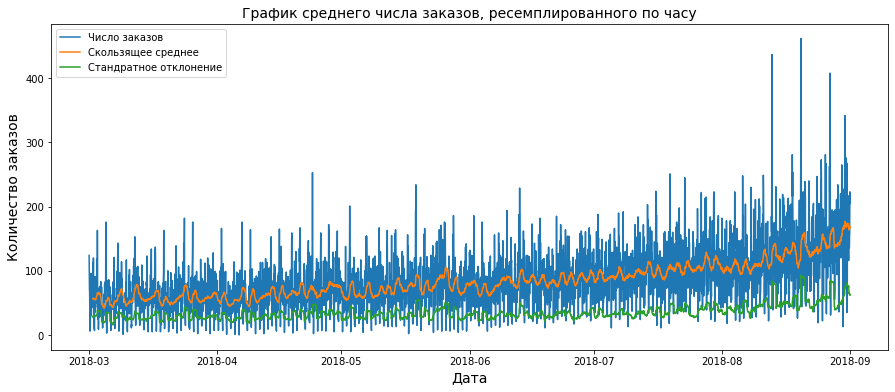

In [9]:
plt.figure(figsize=(15, 6))
plt.plot(data_hour.index, data_hour['num_orders'], label='Число заказов')
plt.plot(data_hour.index, data_hour['rolling_mean'], label='Скользящее среднее')
plt.plot(data_hour.index, data_hour['std'], label='Стандратное отклонение')
plt.title('График среднего числа заказов, ресемплированного по часу', fontsize=14)
plt.xlabel('Дата', fontsize=14)
plt.ylabel('Количество заказов', fontsize=14)
plt.legend()  # Добавление легенды
plt.show()

**Согласно графику видим постепенное повышение числа заказов к концу. Возможная гипотеза - летом и начале осени больше всего отпусков и люди, улетают отдыхать, а возможно что просто люди постепенно привыкают к компании и чаще пользуются сервисом (стало больше клиентов со временем).**

In [10]:
decomposed_day = seasonal_decompose(data_day, period=7)

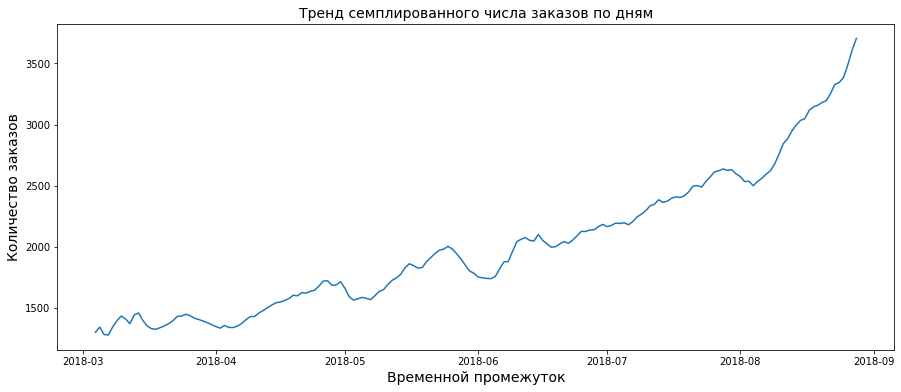

In [11]:
plt.figure(figsize=(15, 6))
plt.plot(decomposed_day.trend)
plt.title('Тренд семплированного числа заказов по дням', fontsize=14)
plt.xlabel('Временной промежуток', fontsize=14)
plt.ylabel('Количество заказов', fontsize=14)
plt.show()

**Видим опять подтверждение прошлых гипотез**

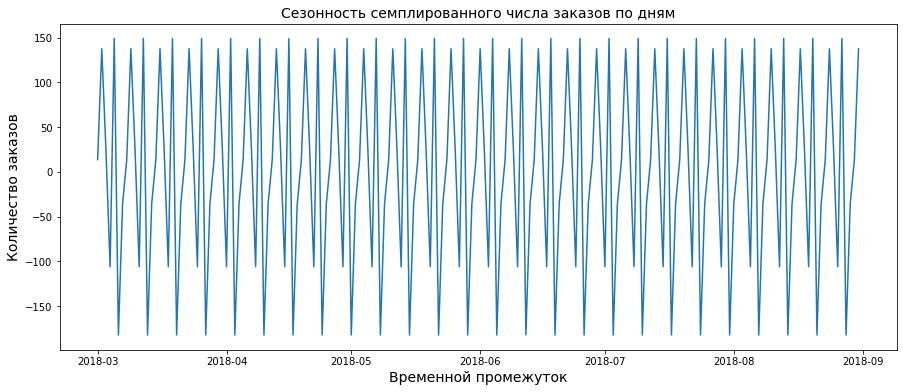

In [12]:
plt.figure(figsize=(15, 6))
plt.plot(decomposed_day.seasonal)
plt.title('Сезонность семплированного числа заказов по дням', fontsize=14)
plt.xlabel('Временной промежуток', fontsize=14)
plt.ylabel('Количество заказов', fontsize=14)
plt.show()

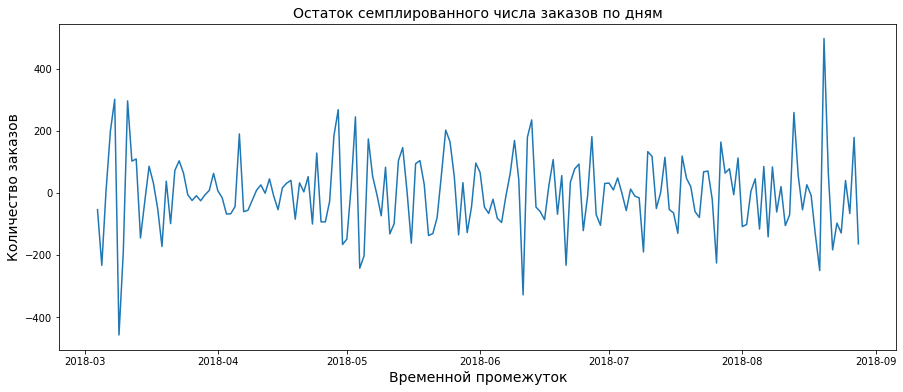

In [13]:
plt.figure(figsize=(15, 6))
plt.plot(decomposed_day.resid)
plt.title('Остаток семплированного числа заказов по дням', fontsize=14)
plt.xlabel('Временной промежуток', fontsize=14)
plt.ylabel('Количество заказов', fontsize=14)
plt.show()

**Провели семплирование наших данных за час и за день. Вычислили скользящее среднее и стандартное отклонение с размером окна равным 24. Провели декомпозицию семплированных данных за день на тренд и сезонность.**

**Согласно графикам сделали вывод о постепенном повышении числа заказов к концу лета и начале осени. Возможная гипотеза - летом и начале осени больше всего отпусков и люди, улетают отдыхать, а возможно что просто люди постепенно привыкают к компании и чаще пользуются сервисом (стало больше клиентов со временем).**

## Обучение

In [14]:
data_hour.head()

,num_orders,rolling_mean,std
datetime,,,
2018-03-01 00:00:00,124,NaN,NaN
2018-03-01 01:00:00,85,NaN,NaN
2018-03-01 02:00:00,71,NaN,NaN
2018-03-01 03:00:00,66,NaN,NaN
2018-03-01 04:00:00,43,NaN,NaN


In [15]:
data_hour = data_hour.drop(['rolling_mean', 'std'], axis=1)

In [16]:
#создадим функцию для создания новых признаков
def make_features(data, max_lag, rolling_mean_size):
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

In [17]:
#применим функцию
make_features(data_hour, 168, 24)

In [18]:
data_hour.head()

,num_orders,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,...,lag_160,lag_161,lag_162,lag_163,lag_164,lag_165,lag_166,lag_167,lag_168,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,71.0,85.0,124.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,3,66.0,71.0,85.0,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
#сбросим все пустые значения
data_hour = data_hour.dropna()

In [20]:
#повторная проверка
data_hour.head()

,num_orders,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,...,lag_160,lag_161,lag_162,lag_163,lag_164,lag_165,lag_166,lag_167,lag_168,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-08 00:00:00,143,3,94.0,127.0,108.0,76.0,50.0,99.0,48.0,46.0,...,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0,60.041667
2018-03-08 01:00:00,78,3,143.0,94.0,127.0,108.0,76.0,50.0,99.0,48.0,...,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,61.833333
2018-03-08 02:00:00,65,3,78.0,143.0,94.0,127.0,108.0,76.0,50.0,99.0,...,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,60.041667
2018-03-08 03:00:00,68,3,65.0,78.0,143.0,94.0,127.0,108.0,76.0,50.0,...,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,61.750000
2018-03-08 04:00:00,60,3,68.0,65.0,78.0,143.0,94.0,127.0,108.0,76.0,...,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,61.833333


In [21]:
num_columns = []
for i in range(1, 169):
    num_columns.append(f"lag_{i}")

In [22]:
num_columns.append('rolling_mean')

In [23]:
#подготовим пайплайн
#построим модели и проверим их гиперпараметры с помощью пайплайна на тренировочной выборке

RANDOM_STATE = 42

train, test = train_test_split(data_hour, shuffle=False, test_size=0.1)
X_train = train.drop('num_orders', axis=1)
X_test = test.drop('num_orders', axis=1)
y_train = train['num_orders']
y_test = test['num_orders']

In [24]:
# создаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [
     ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
)

In [25]:
# создаём итоговый пайплайн: подготовка данных и модель
pipe_final= Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', LinearRegression())
])


In [26]:
param_random = [
    {
        'models': [SVR()],
        'models__kernel': ['linear', 'rbf'],
        'models__C': [0.1, 1, 10],
        'models__epsilon': [0.01, 0.1],
        'preprocessor__num': [MinMaxScaler()]
    },
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': [3, 5, 7],
        'models__min_samples_split': [5, 10, 20],
        'models__min_samples_leaf': [2, 4, 6, 8],
        'models__max_features': ['auto', 'sqrt', 'log2'],
        'preprocessor__num': ['passthrough']
    }
]


In [27]:
# Сначала определим функцию, которая вычисляет RMSE
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Теперь создаем scorer объект.
# greater_is_better=False указывает, что чем МЕНЬШЕ значение, тем лучше.
rmse_scorer = make_scorer(rmse, greater_is_better=False)

In [28]:
tscv = TimeSeriesSplit(n_splits=5)
rsearch = RandomizedSearchCV(estimator=pipe_final, cv=tscv, param_distributions=param_random, scoring=rmse_scorer, n_jobs=-1, random_state=RANDOM_STATE)
rsearch.fit(X_train, y_train)

RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('num',
                                                                               MinMaxScaler(),
                                                                               ['lag_1',
                                                                                'lag_2',
                                                                                'lag_3',
                                                                                'lag_4',
                                                                                'lag_5',
                                                                                'lag_6',
                                       

In [29]:
print('Лучшая модель и её параметры', rsearch.best_estimator_)
print ('Метрика лучшей модели на кросс-валидации:', rsearch.best_score_)

Лучшая модель и её параметры Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', MinMaxScaler(),
                                                  ['lag_1', 'lag_2', 'lag_3',
                                                   'lag_4', 'lag_5', 'lag_6',
                                                   'lag_7', 'lag_8', 'lag_9',
                                                   'lag_10', 'lag_11', 'lag_12',
                                                   'lag_13', 'lag_14', 'lag_15',
                                                   'lag_16', 'lag_17', 'lag_18',
                                                   'lag_19', 'lag_20', 'lag_21',
                                                   'lag_22', 'lag_23', 'lag_24',
                                                   'lag_25', 'lag_26', 'lag_27',
                                                   'lag_28', 'lag_29', 'lag_30', ...]

## Тестирование

In [30]:
y_pred = rsearch.predict(X_test)

In [31]:
y_test = y_test.to_numpy()

In [32]:
scoring_best_model = rmse(y_test, y_pred)
print('Метрика лучшей модели на тестовой выборке:', scoring_best_model)

Метрика лучшей модели на тестовой выборке: 35.05544813535208


## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Данные проанализированы
- [x]  Модель обучена, гиперпараметры подобраны
- [x]  Качество моделей проверено, выводы сделаны
- [x]  Значение *RMSE* на тестовой выборке не больше 48